In [5]:
print("Importing all appropriate libs")
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2
import torch
import matplotlib.pyplot as plt 
import torchvision
import torchsummary
import torch.nn.functional as F
print('torch version:',torch.__version__)
print('numpy version:', np.__version__)
print("torchvision version", torchvision.__version__)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp



#see: https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#make sure external module get reloaded
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Importing all appropriate libs
torch version: 0.4.0
numpy version: 1.15.4
torchvision version 0.2.2


## People counting on  Mall dataset
- dset link: http://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html

In [6]:
dataset_dir = '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/'

In [7]:
!ls '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/'

demo.m	gams	       mall_gt.mat  meta_test.json	 readme.txt
frames	mall_feat.mat  meta.json    perspective_roi.mat


In [8]:
!ls '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/frames' | head -20

frames.zip
seq_000001.jpg
seq_000002.jpg
seq_000003.jpg
seq_000004.jpg
seq_000005.jpg
seq_000006.jpg
seq_000007.jpg
seq_000008.jpg
seq_000009.jpg
seq_000010.jpg
seq_000011.jpg
seq_000012.jpg
seq_000013.jpg
seq_000014.jpg
seq_000015.jpg
seq_000016.jpg
seq_000017.jpg
seq_000018.jpg
seq_000019.jpg
ls: write error: Broken pipe


In [9]:
import glob
import os

In [10]:
image_paths = glob.glob(os.path.join(dataset_dir, 'frames', 'seq_*.jpg'))
print("len", len(image_paths))

len 2000


In [12]:
image_paths.sort()
image_paths[:3]

['/work/cseos2g/datduyn/Documents/datasets/mall_dataset/frames/seq_000001.jpg',
 '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/frames/seq_000002.jpg',
 '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/frames/seq_000003.jpg']

## Examine groundtruth labels

In [52]:
import scipy.io

sample_number = 500 
#ground truth labels is stored in matlab struct files
gt_data = scipy.io.loadmat(os.path.join(dataset_dir, 'mall_gt.mat'))

In [53]:
#sanity check
x_test = gt_data['frame'][0,sample_number][0][0][0]# stored in x,y format of numpy array
x_test.shape

(26, 2)

In [54]:
im_test = cv2.imread(image_paths[sample_number])
im_test.shape

(480, 640, 3)

In [55]:
gt_test = np.zeros(im_test.shape[:2])
gt_test.shape

(480, 640)

In [56]:
mask = x_test.astype(int)

In [57]:
gt_test[mask[:,  1], mask[:,  0]] = 1

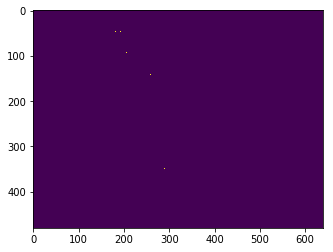

In [58]:
plt.imshow(gt_test)

In [59]:
gt_test.sum()

26.0

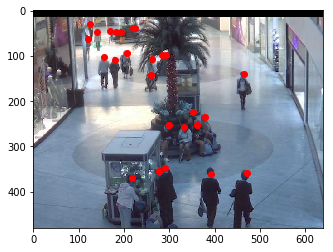

In [60]:
plt.imshow(im_test)
plt.scatter(mask[:,  0], mask[:,  1], c='r')#x, y

## Get dset mean and std

- Last updated (5/12/19)

```
(array([0.53610113, 0.47058904, 0.43273771]),
 array([0.2187217 , 0.21788203, 0.20973989]))
```

In [22]:
def get_mean_std(img_paths, print_freq=20 ) :
    count = 0;
    val_max_img = 255.0;
    mean = np.array([0.] * 3);
    std = np.array([0.] * 3);
    for fname in sorted(img_paths) :
        count += 1;
        im = cv2.imread(fname, cv2.IMREAD_UNCHANGED);
        mean += im.mean(axis=(0,1))/val_max_img;
        std += im.std(axis=(0,1))/val_max_img;
        if (count%print_freq) == 0:
            print ("Done processing image = {}".format(count));

    mean /= count;
    std /= count;

    # swap R and B channel values
    tmp = mean[0];
    mean[0] = mean[2];
    mean[2] = tmp;
    tmp = std[0];
    std[0] = std[2];
    std[2] = tmp;

    return mean, std;

In [23]:
get_mean_std(image_paths[:200])

Done processing image = 10
Done processing image = 20
Done processing image = 30
Done processing image = 40
Done processing image = 50
Done processing image = 60
Done processing image = 70
Done processing image = 80
Done processing image = 90
Done processing image = 100
Done processing image = 110
Done processing image = 120
Done processing image = 130
Done processing image = 140
Done processing image = 150
Done processing image = 160
Done processing image = 170
Done processing image = 180
Done processing image = 190
Done processing image = 200


(array([0.53610113, 0.47058904, 0.43273771]),
 array([0.2187217 , 0.21788203, 0.20973989]))

## Generate Gaussian Activation Map

In [10]:
from scipy import ndimage
#borrowed from #this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    #thanks to: https://gist.github.com/iamtekeste/3cdfd0366ebfd2c0d805
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 1000
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
#     print ('done.')
    return density

In [90]:
#sanity check
test_gam = gaussian_filter_density(gt_test)

Text(0.5, 1.0, 'Gaussian map')

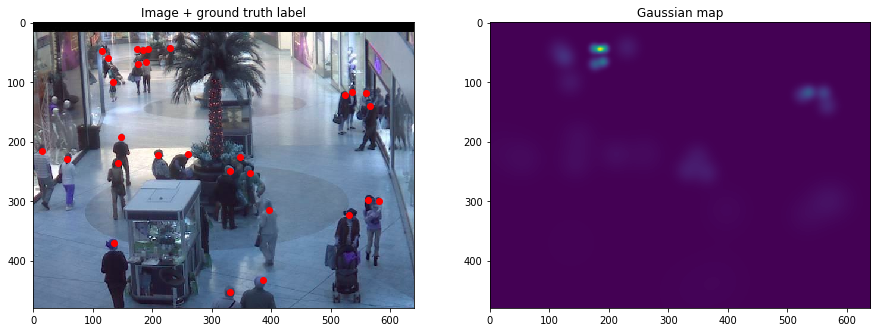

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axs[0].imshow(im_test)
axs[0].scatter(mask[:,  0], mask[:,  1], c='r')
axs[0].set_title("Image + ground truth label")

axs[1].imshow(test_gam)
axs[1].set_title("Gaussian map")


In [93]:
print("Groudth truth count", gt_test.sum())
print("Gaussian map estimate count", test_gam.sum())

Groudth truth count 29.0
Gaussian map estimate count 28.295473


## Save GAM map to file

```
# Save to file
np.save('BunchOfFloats.npy',b)

# Read back into different array "r"
r = np.load('BunchOfFloats.npy')
```

In [11]:
import pickle

In [101]:
for i in range(200):
    groundtruth_label = gt_data['frame'][0,i][0][0][0].astype(int)
    gt_map = np.zeros(im_test.shape[:2])
    gt_map[groundtruth_label[:,  1], groundtruth_label[:,  0]] = 1
    
    gam_map = gaussian_filter_density(gt_map)
    file_name = os.path.join(dataset_dir, 'gams', 
                             'gam_'+str(i+1).zfill(6)+'.pkl')
    with open(file_name, 'wb') as f:
        pickle.dump(gam_map, f)
    if (i % 10) ==  0:
        print("Done processing", i)
#     np.save(file_name, gam)

Done processing 0
Done processing 10
Done processing 20
Done processing 30
Done processing 40
Done processing 50
Done processing 60
Done processing 70
Done processing 80
Done processing 90
Done processing 100
Done processing 110
Done processing 120
Done processing 130
Done processing 140
Done processing 150
Done processing 160
Done processing 170
Done processing 180
Done processing 190


## Make test batch

In [22]:
for i in range(400, 450):
    groundtruth_label = gt_data['frame'][0,i][0][0][0].astype(int)
    gt_map = np.zeros(im_test.shape[:2])
    gt_map[groundtruth_label[:,  1], groundtruth_label[:,  0]] = 1
    
    gam_map = gaussian_filter_density(gt_map)
    file_name = os.path.join(dataset_dir, 'gams', 
                             'gam_'+str(i+1).zfill(6)+'.pkl')
    with open(file_name, 'wb') as f:
        pickle.dump(gam_map, f)
    if (i % 10) ==  0:
        print("Done processing", i)
#     np.save(file_name, gam)

Done processing 400
Done processing 410
Done processing 420
Done processing 430
Done processing 440


### load a test gam images for sanity check

In [102]:
with open(os.path.join(dataset_dir, 'gams', 'gam_000000.pkl'), 'rb') as f:
    test_gam_np = pickle.load(f)

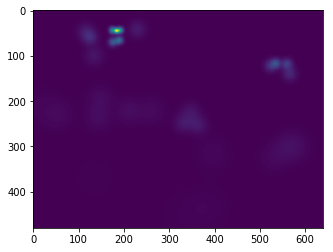

In [103]:
plt.imshow(test_gam_np)

In [23]:
gam_paths = glob.glob(os.path.join(dataset_dir, 'gams', 'gam_*.pkl'))
print("len", len(gam_paths))

len 250


In [24]:
gam_paths.sort()
gam_paths[:3]

['/work/cseos2g/datduyn/Documents/datasets/mall_dataset/gams/gam_000000.pkl',
 '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/gams/gam_000001.pkl',
 '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/gams/gam_000002.pkl']

In [135]:
mall_dataset_meta = {
    'meta' : "Labels is stored in x, y order",
    'images' : image_paths[:200],
    'gams' : gam_paths[:200], 
    'labels' : [gt_data['frame'][0,i][0][0][0].astype(int).tolist() for i in range(200)]
}

In [26]:
mall_dataset_test_meta = {
    'meta' : "Labels is stored in x, y order",
    'images' : image_paths[400:450],
    'gams' : gam_paths[-50:], 
    'labels' : [gt_data['frame'][0,i][0][0][0].astype(int).tolist() for i in range(400,450)]
}

In [29]:
len(mall_dataset_test_meta['labels'][0])

48

## Save in a file. (Do Once)


In [31]:
import json

In [137]:
##Run Once only
with open(os.path.join(dataset_dir, 'meta.json'), 'w') as file:
    json.dump(mall_dataset_meta, file, indent=4)

In [32]:
#save test
with open(os.path.join(dataset_dir, 'meta_test.json'), 'w') as file:
    json.dump(mall_dataset_test_meta, file, indent=4)